<b><font color='darkred'>
FFNN - Feed Forward Neural Network
-----------------
➔ Einfaches Feed-Forward-Netz

- Subsampling wie in subsample3.ipynb
- Zielgröße muss skaliert werden, um vernünftige Daten zu bekommen, kann mit 2. Dense(1)-Layer ohne Bias automatisch
  erfolgen (eingebaut)
- deutlich schlechter als SVR

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics, manifold
from tensorflow import keras
import keras_tuner as kt

import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
best_subsample_size = 32
SCALE = 2000

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

<b><font color='lightgreen'> Daten mischen & in Trainings-, Test- und Validierungsdaten aufteilen

In [6]:
versuche_train_valid, versuche_test_valid = model_selection.train_test_split(versuche_train, test_size=0.1)
versuche_train_valid.shape, versuche_test_valid.shape, versuche_test.shape

# versuche_train       = versuche_train_valid
# versuche_train_valid = versuche_train
# versuche_test_valid  = versuche_valid

((432, 5), (48, 5), (120, 5))

<b><font color='lightgreen'> Daten nach optimaler Subsampling-Size transformieren

In [7]:
subsample = helper.Subsample(best_subsample_size, ts_len=None)
subsample.fit() 

Subsample(subsample=32)

In [8]:
X_train = subsample.transform(versuche_train_valid.key, kurven)
label_train      = versuche_train_valid.label.values
festigkeit_train = versuche_train_valid.festigkeit.values

print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))

X_valid = subsample.transform(versuche_test_valid.key, kurven)
label_valid      = versuche_test_valid.label.values
festigkeit_valid = versuche_test_valid.festigkeit.values

print(X_valid.shape, label_valid.shape)
print(X_valid.max(axis=(0,1)))

X_test = subsample.transform(versuche_test.key, kurven)
label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

print(X_test.shape)
print(X_test.max(axis=(0,1)))

(432, 32, 3) (432,)
[3544.08   625.019    4.14 ]
(48, 32, 3) (48,)
[3563.91   621.113    3.89 ]
(120, 32, 3)
[3532.82   623.066    3.82 ]


<b><font color='lightgreen'> Daten skalieren

In [9]:
tsMaxScale = helper.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)
X_test_scaled  = tsMaxScale.transform(X_test)

festigkeit_train = festigkeit_train/SCALE
festigkeit_valid = festigkeit_valid/SCALE
festigkeit_test  = festigkeit_test/SCALE

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

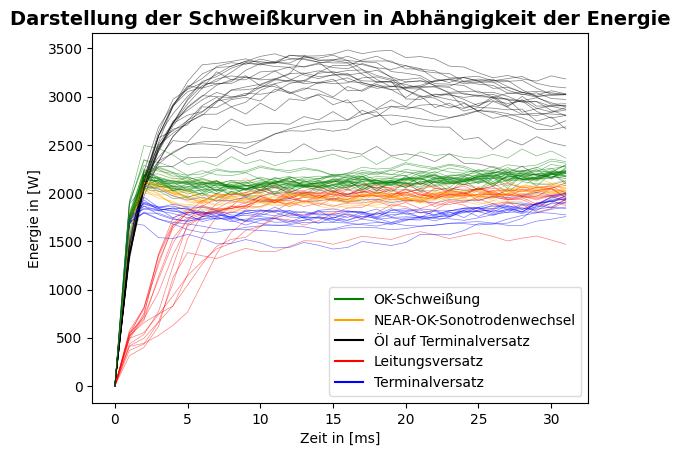

In [10]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
# Komplette Kurve auf 26 (best_result['subsample_size'] Zeitpunkte in gleichem Abstand approximiert

<font color='lightgreen'> zunächst nur Power verwenden (Vergleich SVR)

In [11]:
dims = X_train.shape
X2_train = X_train_scaled[:,:,0]
X2_valid = X_valid_scaled[:,:,0]
X2_test  = X_test_scaled[:,:,0]

<b><font color='lightgreen'> Klassifikation</b>
- Maximierung von val_accuracy

In [12]:
def build_class(hp):
    n_hidden  = hp.Int("n_hidden",  min_value=1,  max_value=5, default=2)
    n_neurons = hp.Int("n_neurons", min_value=10, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling='log')
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(5, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [13]:
random_search_tuner = kt.RandomSearch(
    build_class, 
    objective='val_accuracy', 
    overwrite=True,
    max_trials=5,
    seed=42)
    # directory='ann1', project_name='ann1_class',

random_search_tuner.search(X2_train, label_train, epochs=30,
    validation_data=(X2_valid, label_valid)
)

Trial 5 Complete [00h 00m 01s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 05s


<b><font color='lightgreen'> bestes Modell

In [14]:
model = random_search_tuner.get_best_models(num_models=1)[0]
hp    = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values

{'n_hidden': 5, 'n_neurons': 32, 'learning_rate': 0.007902373711581125}

<b><font color='lightgreen'> Modellbewertung</b>

In [15]:
score_train = model.evaluate(X2_train, label_train)
score_test  = model.evaluate(X2_test,  label_test)

pd.DataFrame({ 'Metric': ['Loss', 'Accuracy'], 'Train': score_train, 'Test': score_test}).set_index('Metric').round(3)

4/4 [==============================] - 0s 763us/step - loss: 0.1638 - accuracy: 0.9917


,Train,Test
Metric,,
Loss,0.134,0.164
Accuracy,0.979,0.992


In [16]:
# Klassen basierend auf den höchsten Wahrscheinlichkeiten auswählen
# pred_train = np.argmax(model.predict(X2_train), axis=1)
pred_test  = np.argmax(model.predict(X2_test), axis=1)

4/4 [==============================] - 0s 717us/step


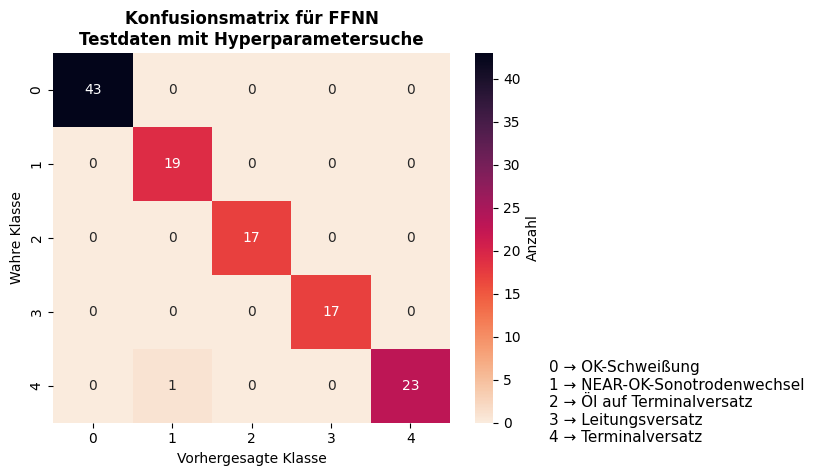

In [17]:
helper.plot_confusion(label_test, pred_test, 'FFNN\nTestdaten mit Hyperparametersuche')

<b><font color='lightgreen'> Regression</b>
- Minimierung von val_loss (Validierungs-MSE)

In [18]:
def build_reg(hp):
    n_hidden  = hp.Int("n_hidden",  min_value=1,  max_value=10, default=2)
    n_neurons = hp.Int("n_neurons", min_value=32, max_value=128)
    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-2, sampling='log')
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer='he_normal', use_bias=False))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu')) # combine outputs
    model.add(keras.layers.Dense(1, use_bias=False))    # scale
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model

In [19]:
random_search_tuner = kt.RandomSearch(
    build_reg, 
    objective='val_loss', 
    overwrite=True, 
    max_trials=10,
    seed=42)
    #directory='ann1', project_name='ann1_reg',

random_search_tuner.search(X2_train, festigkeit_train, epochs=30,
    batch_size=8,
    validation_data=(X2_valid, festigkeit_valid)
)

Trial 10 Complete [00h 00m 03s]
val_loss: 1.4375916719436646

Best val_loss So Far: 0.008746224455535412
Total elapsed time: 00h 00m 22s


In [20]:
hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values

{'n_hidden': 4, 'n_neurons': 79, 'learning_rate': 0.008472109609030772}

In [21]:
model_reg = random_search_tuner.get_best_models(num_models=1)[0]
model_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 79)                2528      
                                                                 
 batch_normalization (Batch  (None, 79)                316       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 79)                0         
                                                                 
 dense_1 (Dense)             (None, 79)                6241      
                                                                 
 batch_normalization_1 (Bat  (None, 79)                316       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 79)                0

<b><font color='lightgreen'> Vorhersage Trainings-, Validierungs- und Testdaten

In [22]:
y_pred_train = model_reg.predict(X2_train)
y_pred_valid = model_reg.predict(X2_valid)
y_pred_test = model_reg.predict(X2_test)

4/4 [==============================] - 0s 705us/step


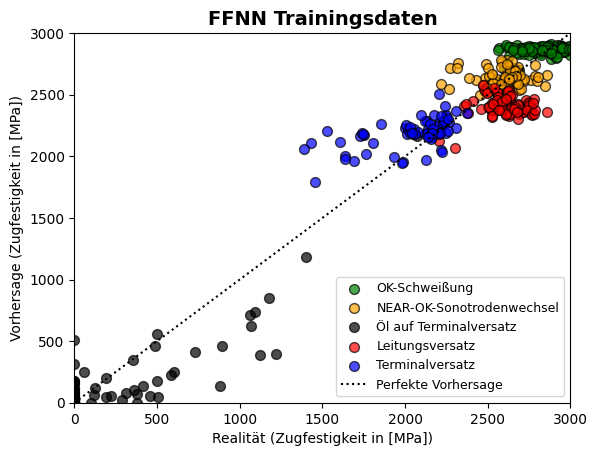

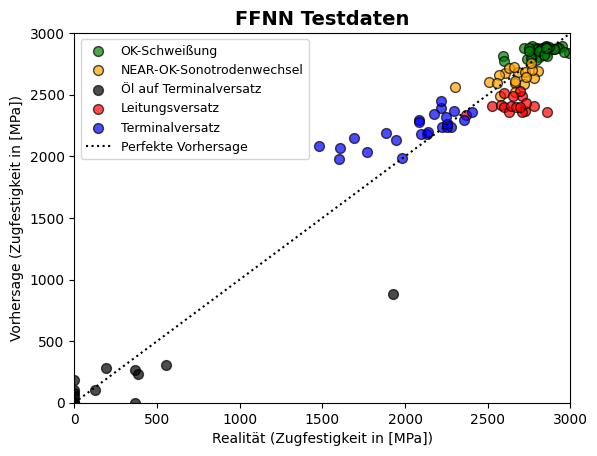

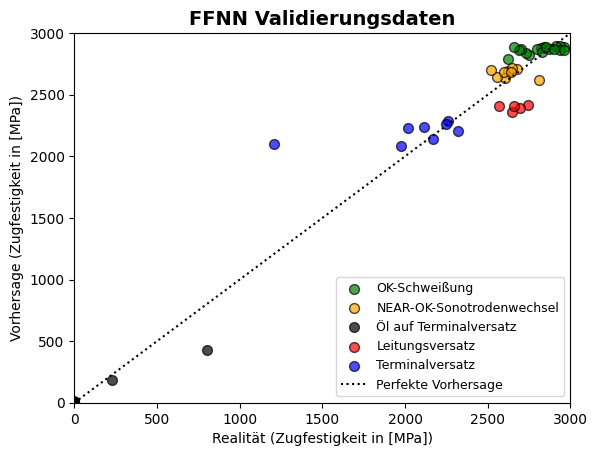

In [23]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'FFNN Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'FFNN Testdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_valid, festigkeit_valid, label_valid, 'FFNN Validierungsdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [24]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,39270.63,37002.60
RMSE,198.17,192.36
MAE,142.47,125.37
R²,0.96,0.95
